## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_horizontal_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\segmentAnything\\full\\wavelet\\horizontal\\blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


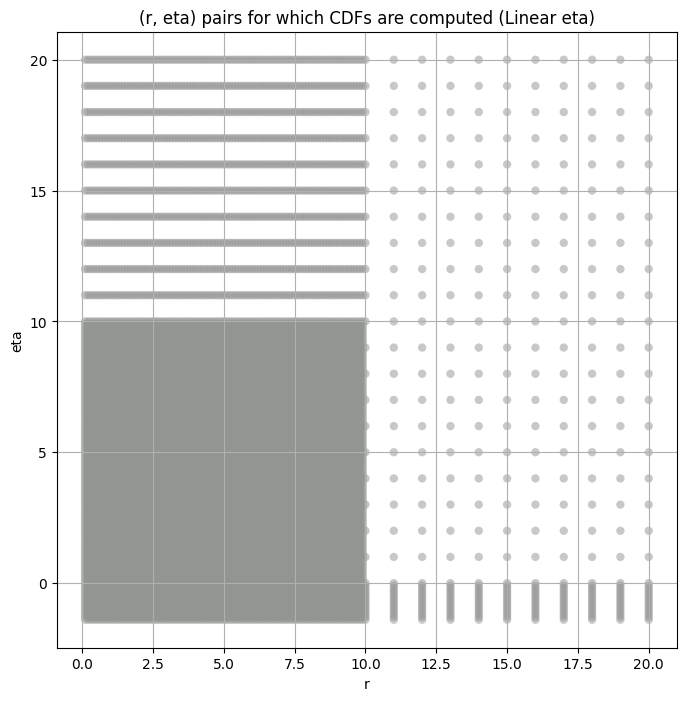

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      18950.691000  18034.914000  19884.934000   0.555051    0.361059   
3       4388.561500   4176.722000   4603.724600   1.555216    1.292626   
4       1007.044070    950.235700   1065.644300   2.910003    2.394928   
5        229.104720    214.613650    244.353060   4.434873    3.485563   
6         50.963154     47.393555     54.791560   5.817626    4.435262   
7         11.331628     10.483869     12.258407   7.224944    5.307698   
8          2.534626      2.331055      2.771307   9.098009    5.957001   
9          0.600995      0.548408      0.671857  12.860447    6.738958   
10         0.146608      0.131844      0.169582  20.812674    8.569079   

       kurt_upper  total_samples  
layer                             
2        0.770263           7072  
3        1.843574          28288  
4        3.597748         113152  
5        6.828188         452608  
6       10.859207        1810432  
7       14.322908        7241728  
8       24.061966       28966912  
9       48.073174      115867648  
10      91.798670      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      18950.691000   18950.691406    17660.843750    16773.767578   
3       4388.561500    4388.561523     4258.673340     4163.867676   
4       1007.044070    1007.044067      991.939148      980.575867   
5        229.104720     229.104721      224.347809      221.206284   
6         50.963154      50.963154       49.730534       48.928894   
7         11.331628      11.331628       11.015017       10.818002   
8          2.534626       2.534626        2.452577        2.404964   
9          0.600995       0.600995        0.577895        0.565643   
10         0.146608       0.146608        0.139424        0.135902   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        16007.815430     15330.321289     14158.598633     13178.517578   
3         4081.398438      4005.802002      3869.851318      3748.385498   
4          970.460632       961.227112       944.616516       929.675232   
5          218.494064       216.051910       211.666473       207.717590   
6           48.238441        47.616562        46.507271        45.520584   
7           10.649342        10.498009        10.228262         9.989235   
8            2.364414         2.328132         2.263921         2.207351   
9            0.555264         0.546013         0.529739         0.515492   
10           0.132954         0.130350         0.125816         0.121893   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         12316.715820     11539.864258     10832.359375      9037.067383  
3          3637.205811      3534.754150      3438.651367      3180.494873  
4           915.848755       903.030762       891.006836       858.331665  
5           204.087738       200.722549       197.565552       189.042297  
6            44.622532        43.792076        43.016872        40.941730  
7             9.772481         9.572734         9.386535         8.890409  
8             2.156178         2.109179         2.065539         1.949842  
9             0.502679         0.490960         0.480119         0.451556  
10            0.118399         0.115230         0.112323         0.104761

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.04930702370328377 18950.691


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.04953452403609404 17660.844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.049696989880980535 16773.768


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.04996054791124416 16007.815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.050195938027012055 15330.321


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.05057053369526293 14158.599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.05078876779899949 13178.518


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.05391095165453119 12316.716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.059899020859808694 11539.864


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.06741144433009294 10832.359


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.08842654469530065 9037.067
Number of samples: 7072, Without approximation : 7072


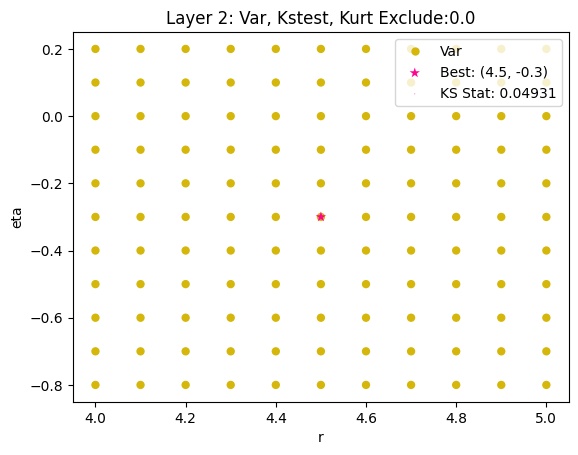

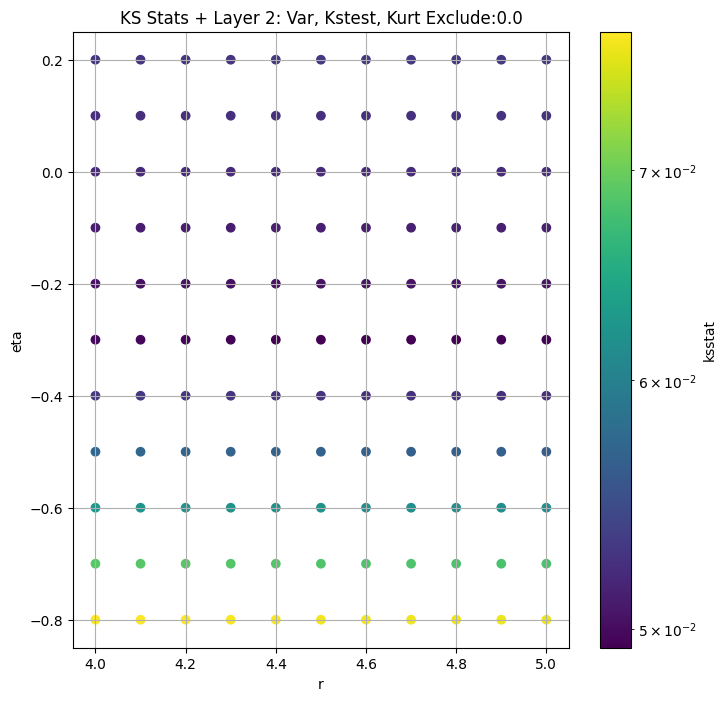

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.038770508226645295 4388.5615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.03878040374207836 4258.6733


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.03876971487217695 4163.8677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.038770978089098684 4081.3984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.03879551126093911 4005.802


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03877545426971657 3869.8513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.0387704293197324 3748.3855


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.03883914039293501 3637.2058


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.03877473899493633 3534.7542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.03881232937388879 3438.6514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.03878631695162266 3180.4949
Number of samples: 28288, Without approximation : 28288


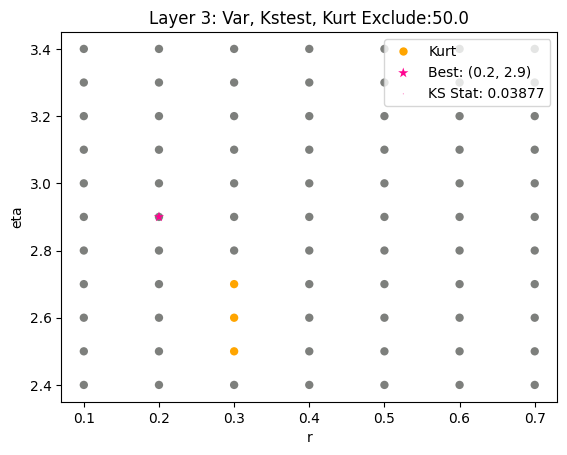

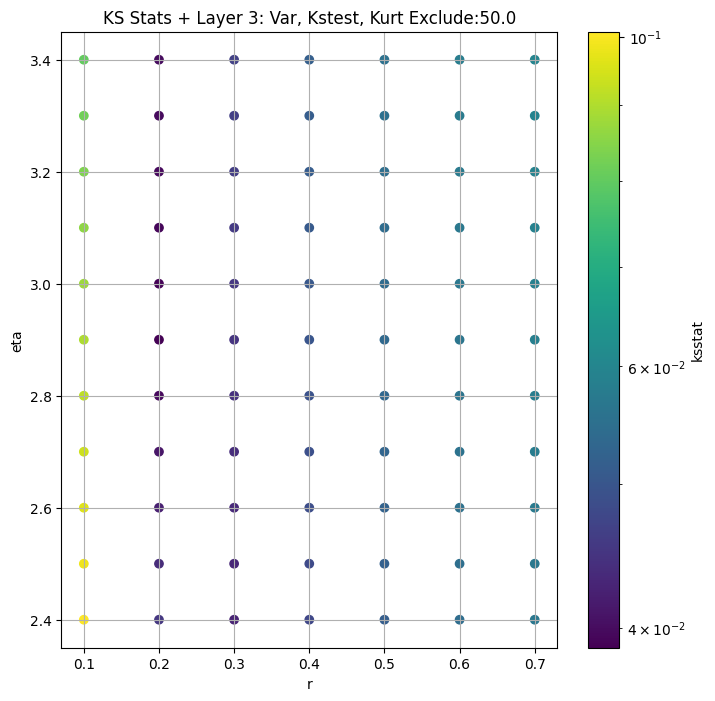

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.030951589187144468 1007.04407


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.030899536268929828 991.93915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.03086214668420678 980.57587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.030931768550203353 970.46063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.030864520827912745 961.2271


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.030812346597798912 944.6165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.030883624485398997 929.67523


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.03089746628722284 915.84875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.03090719799719971 903.03076


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.030919664115145462 891.00684


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.030865096871701525 858.33167
Number of samples: 100000, Without approximation : 113152


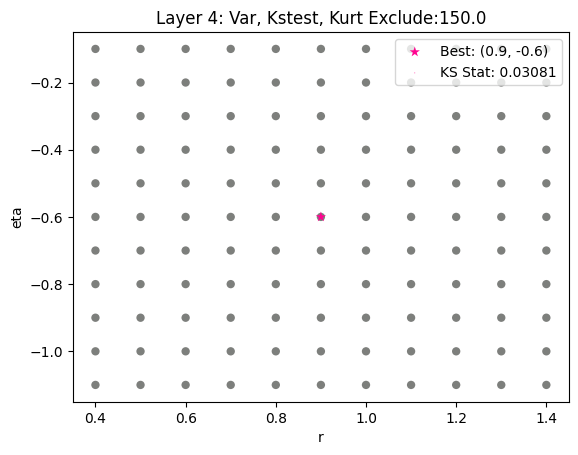

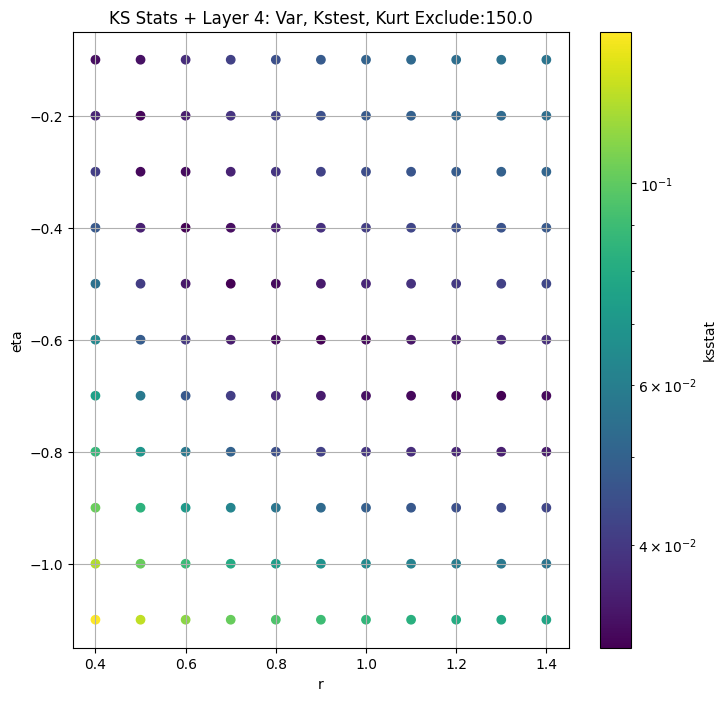

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.018410125916809572 229.10472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.018262849285859584 224.34781


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.018181319525304107 221.20628


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.018109536385994607 218.49406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.018198452756331363 216.05191


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.018420560198229796 211.66647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.01837589158606645 207.71759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.01840002425490256 204.08774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.018268860772804763 200.72255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.018149121005178903 197.56555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.01834651558809075 189.0423
Number of samples: 100000, Without approximation : 452608


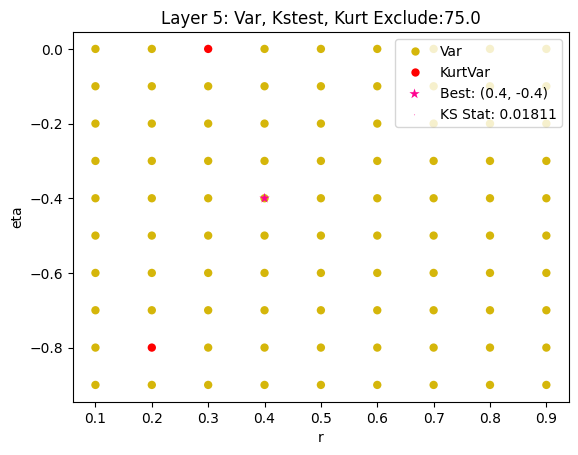

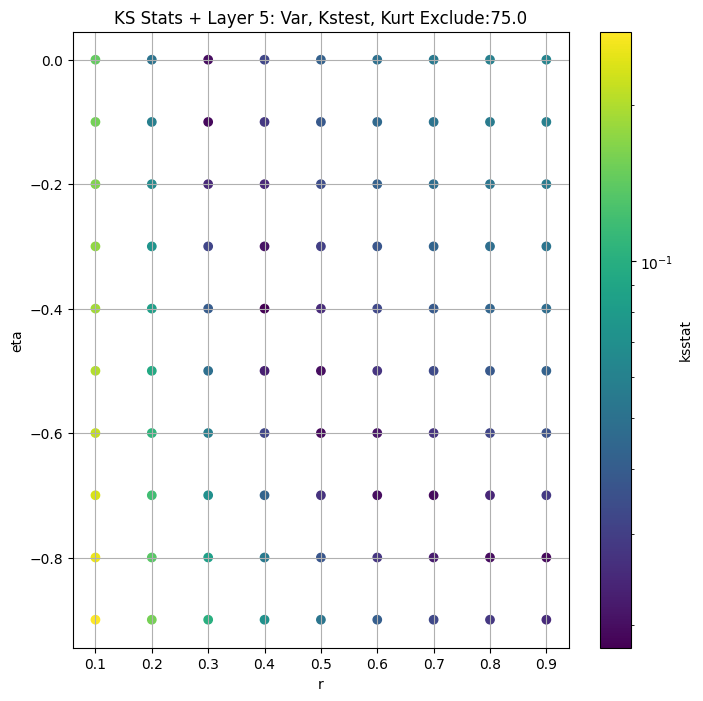

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.009878514796678561 50.963154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.009736667484522288 49.730534


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.00940051148744303 48.928894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.00909010908031882 48.23844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009696213158785993 47.61656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.010563946958141446 46.50727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.010852924931710084 45.520584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.011025675876711216 44.62253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.010403729459050715 43.792076


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.011024349145969059 43.016872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.01127676388222254 40.94173
Number of samples: 100000, Without approximation : 1810432


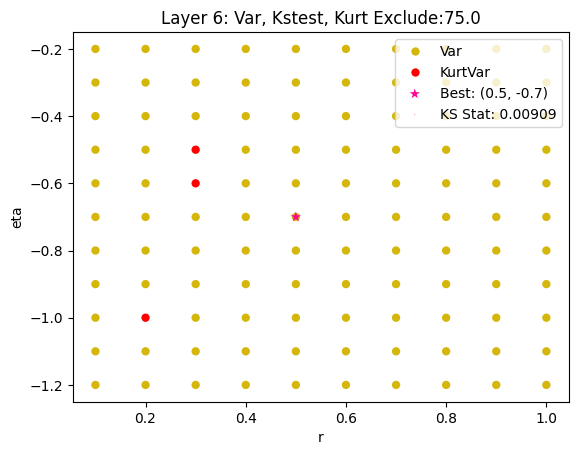

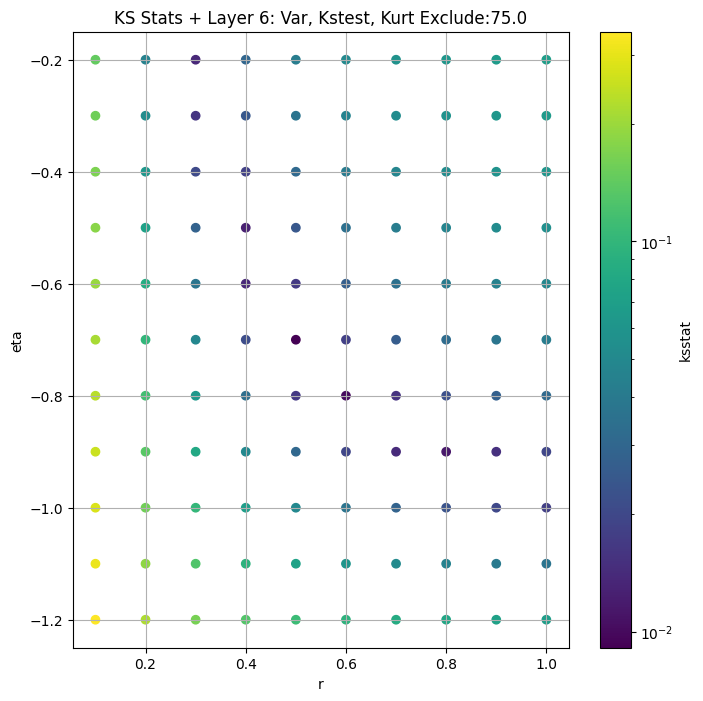

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.006553276467551605 11.331628


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.006392509406942248 11.015017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.006600154648744527 10.818002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.007040723601712706 10.649342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.007266164916886364 10.498009


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.008115322907971012 10.228262


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.00799157951896362 9.989235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.008241580545074068 9.772481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.00916205224361999 9.572734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.009347803666332255 9.386535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.009889355417758261 8.8904085
Number of samples: 100000, Without approximation : 7241728


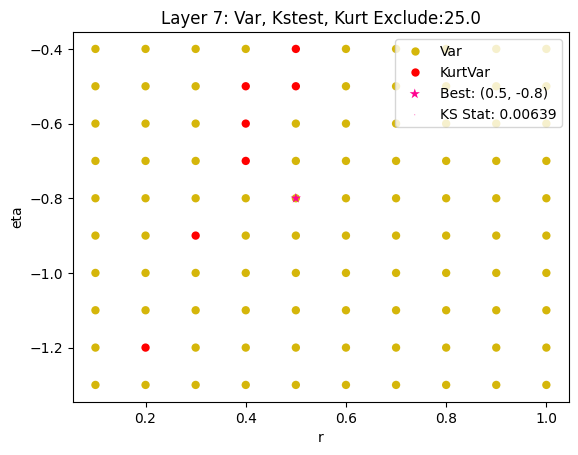

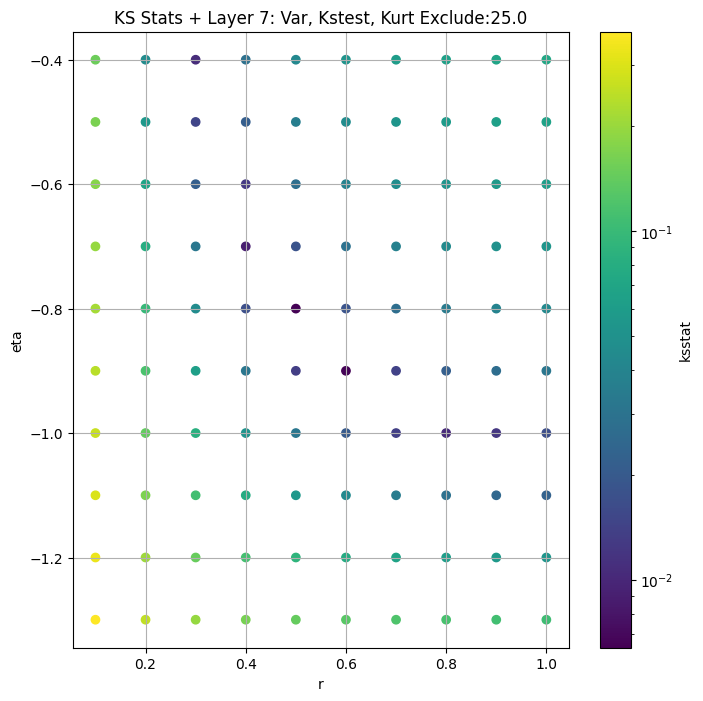

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.005677795327513113 2.5346262


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006425404636807186 2.4525766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.007465324053654299 2.4049644


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.008396906473136623 2.364414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.008032018865011092 2.3281317


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.006443698708764378 2.2639205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.007007742283183127 2.2073507


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.007395230317638113 2.1561785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0077813412396664505 2.1091795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007908166861718136 2.065539


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.009769163263641745 1.9498422
Number of samples: 100000, Without approximation : 28966912


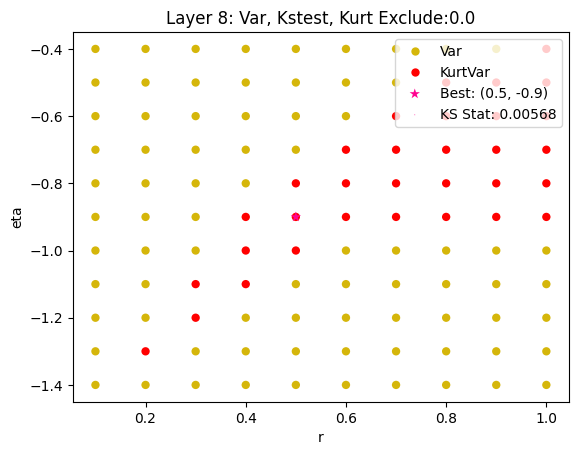

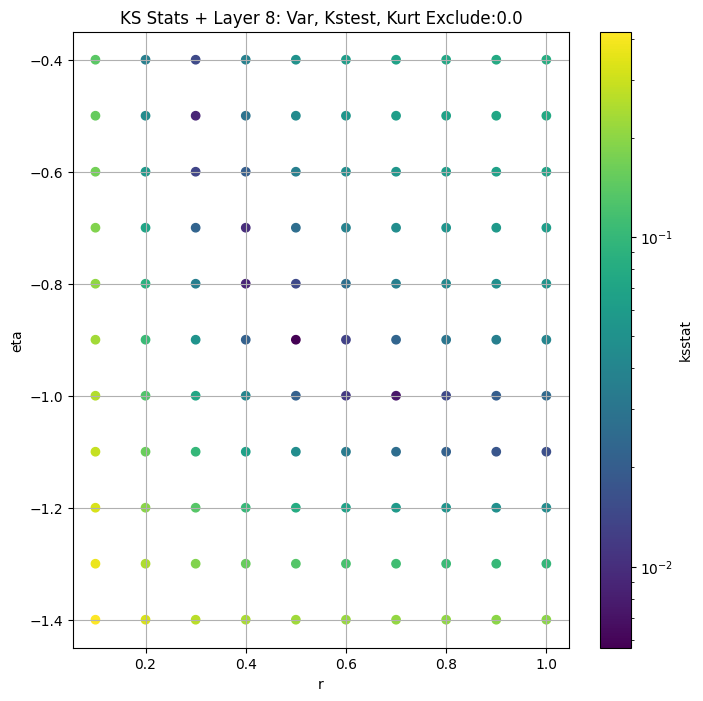

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.005399278594325929 0.6009948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.006893721379546913 0.5778948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.00552374866144284 0.5656431


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.005978069181292733 0.55526406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006803607066387052 0.5460132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.007824604214417774 0.5297395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.007924282205827304 0.515492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.00839586312253432 0.5026787


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008853847232323742 0.4909599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.008857048491131392 0.480119


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.01054352689335103 0.4515556
Number of samples: 100000, Without approximation : 115867648


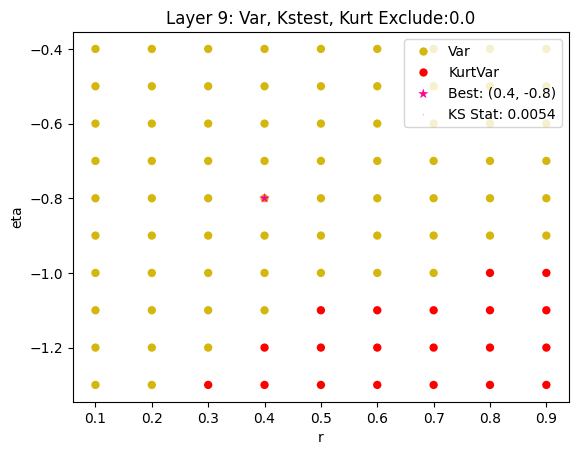

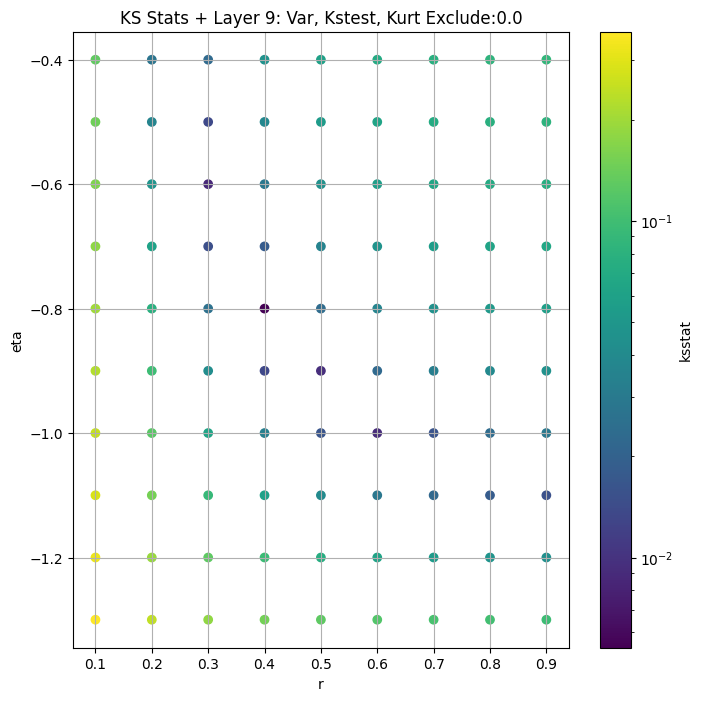

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.006648139762901795 0.14660835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.005445616576788159 0.1394238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.005816733873271418 0.13590157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.006144689203958331 0.13295409


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.0052279483005672756 0.13035044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.006600761348868445 0.12581636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.006146678777615412 0.12189299


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.007196876214762726 0.118398584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.008237592026991702 0.11523033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.008210014216657457 0.11232263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.00956130289504406 0.10476071
Number of samples: 100000, Without approximation : 463470592


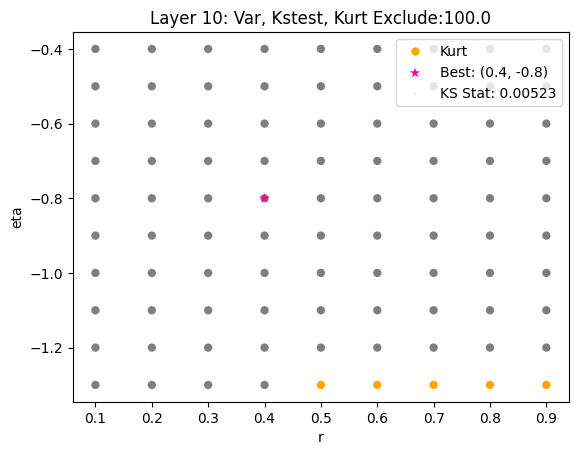

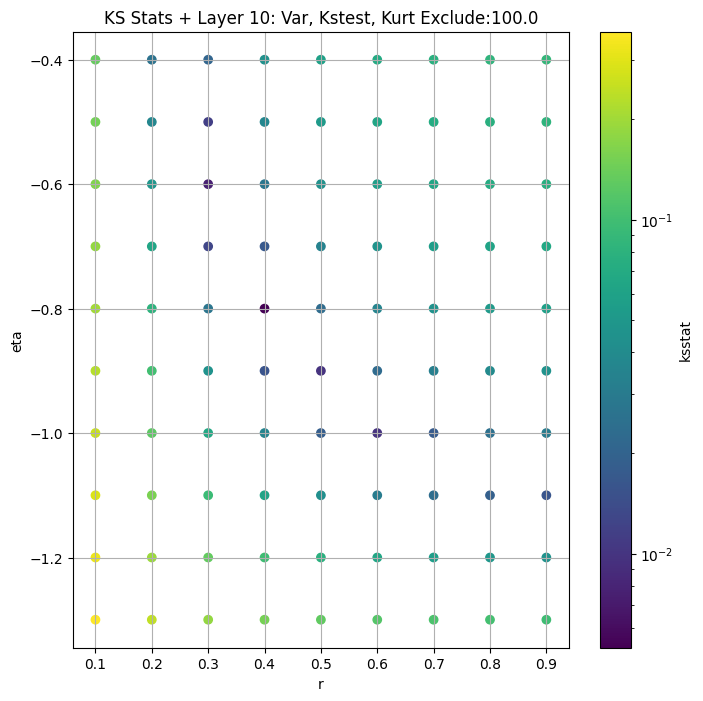

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      18950.691000  18034.914000  19884.934000   0.555051    0.361059   
3       4388.561500   4176.722000   4603.724600   1.555216    1.292626   
4       1007.044070    950.235700   1065.644300   2.910003    2.394928   
5        229.104720    214.613650    244.353060   4.434873    3.485563   
6         50.963154     47.393555     54.791560   5.817626    4.435262   
7         11.331628     10.483869     12.258407   7.224944    5.307698   
8          2.534626      2.331055      2.771307   9.098009    5.957001   
9          0.600995      0.548408      0.671857  12.860447    6.738958   
10         0.146608      0.131844      0.169582  20.812674    8.569079   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.770263           7072             0.049307        4.5         -0.3   
3        1.843574          28288             0.038770        0.2          2.9   
4        3.597748         113152             0.030812        0.9         -0.6   
5        6.828188         452608             0.018110        0.4         -0.4   
6       10.859207        1810432             0.009090        0.5         -0.7   
7       14.322908        7241728             0.006393        0.5         -0.8   
8       24.061966       28966912             0.005678        0.5         -0.9   
9       48.073174      115867648             0.005399        0.4         -0.8   
10      91.798670      463470592             0.005228        0.4         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       35417.588933                     0.0        18950.691000   
3           0.000527                    50.0         4163.867700   
4         897.767659                   150.0          944.616500   
5           9.980145                    75.0          218.494060   
6          11.595779                    75.0           48.238440   
7           3.278279                    25.0           11.015017   
8           0.960086                     0.0            2.534626   
9           0.066668                     0.0            0.600995   
10          0.014460                   100.0            0.130350   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.053954913349303135, var: 15330.3212890625


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.05027668722045653, var: 16007.8154296875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.049904214989103246, var: 16773.767578125


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.04997097957962576, var: 17660.84375


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.04930702370328377, var: 18950.69140625
Number of samples: 7072, Without approximation : 7072


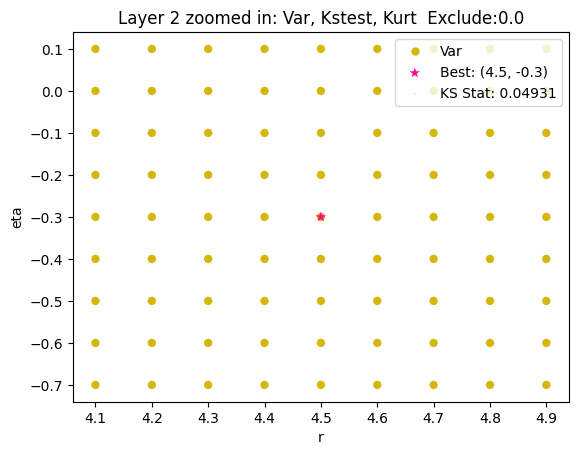

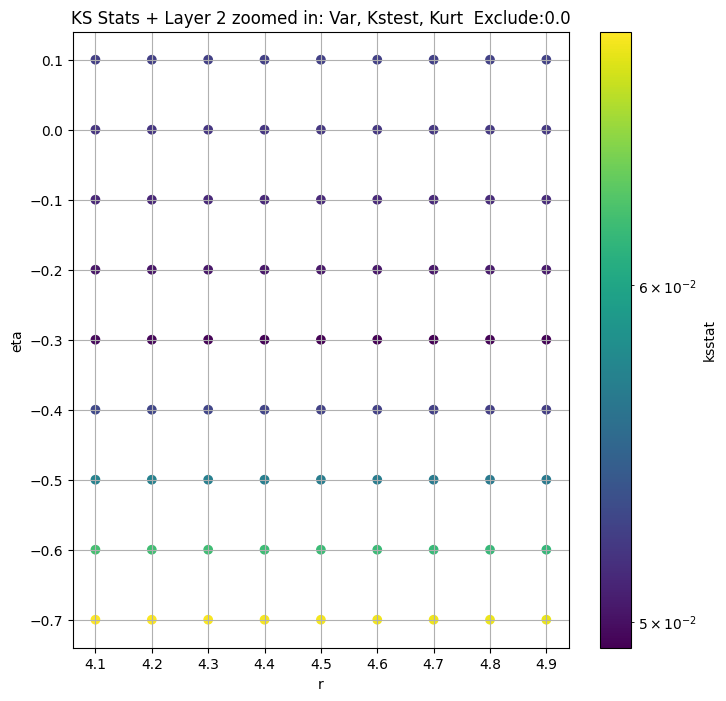

Layer 3


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 50.0 + 100 = 150, ksstat: 0.03893950334592944, var: 3869.851318359375


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 50.0 + 75 = 125, ksstat: 0.03891234453807085, var: 3935.578369140625


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 50.0 + 50 = 100, ksstat: 0.038777947033853066, var: 4005.802001953125


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 50.0 + 25 = 75, ksstat: 0.03876934054620973, var: 4081.3984375


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 50.0 + 0 = 50, ksstat: 0.03876971487217695, var: 4163.86767578125


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 50.0 + -25 = 25, ksstat: 0.038770545603552975, var: 4258.67333984375


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 50.0 + -50 = 0, ksstat: 0.03879056683520771, var: 4388.5615234375
Number of samples: 28288, Without approximation : 28288


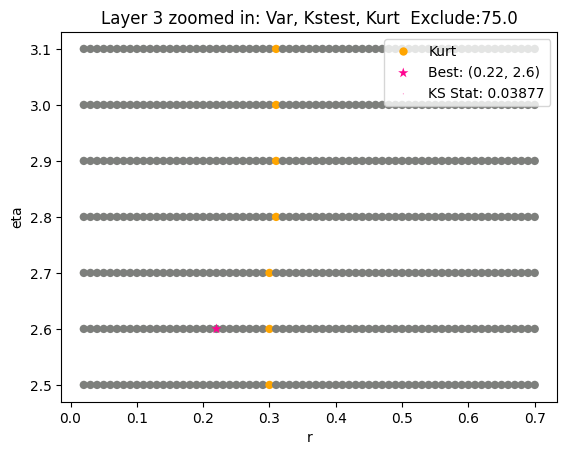

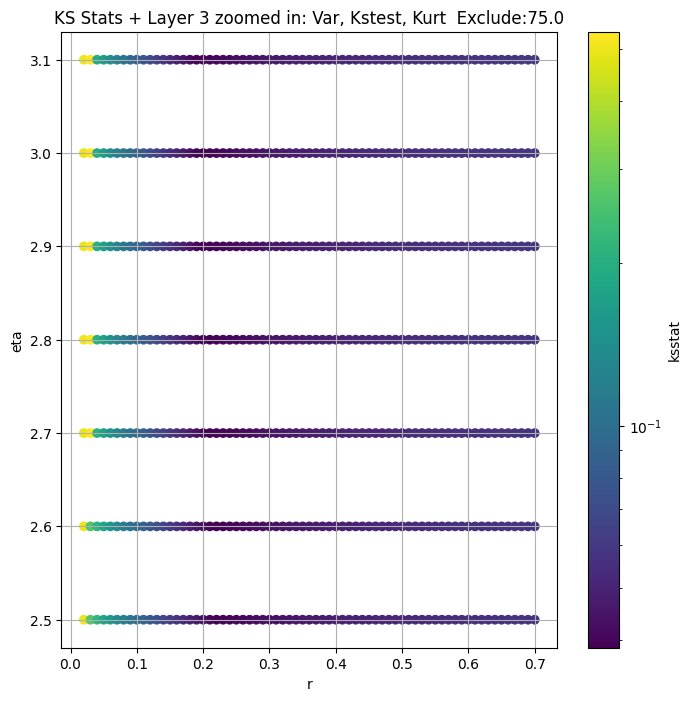

Layer 4


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + 100 = 250, ksstat: 0.03079100066761048, var: 915.8487548828125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + 75 = 225, ksstat: 0.0307934165790818, var: 922.621337890625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + 50 = 200, ksstat: 0.030805775178153805, var: 929.6752319335938


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + 25 = 175, ksstat: 0.03080701500089328, var: 936.9761352539062


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + 0 = 150, ksstat: 0.030790424299652785, var: 944.6165161132812


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + -25 = 125, ksstat: 0.030788392592425107, var: 952.6739501953125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + -50 = 100, ksstat: 0.030792446548646324, var: 961.2271118164062


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + -75 = 75, ksstat: 0.03080305388951704, var: 970.4606323242188


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 150.0 + -100 = 50, ksstat: 0.0307896835051778, var: 980.5758666992188
Number of samples: 100000, Without approximation : 113152


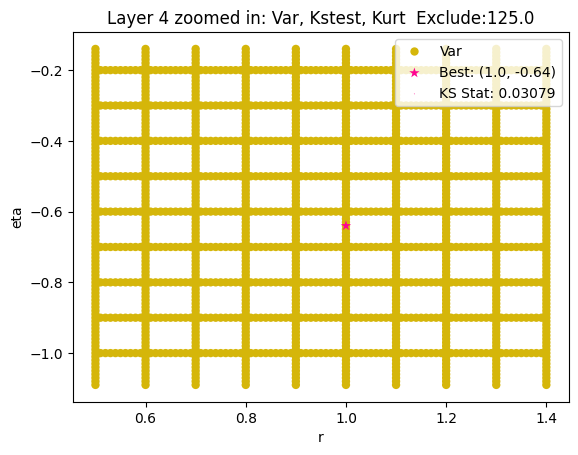

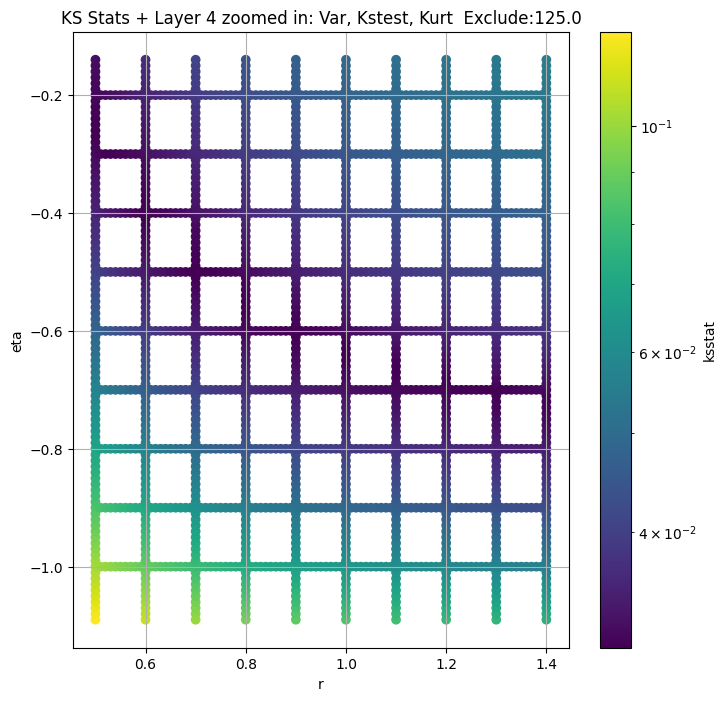

Layer 5


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + 100 = 175, ksstat: 0.018140419883646897, var: 209.6470184326172


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + 75 = 150, ksstat: 0.0180950680206457, var: 211.66647338867188


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + 50 = 125, ksstat: 0.018120731780689348, var: 213.79405212402344


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + 25 = 100, ksstat: 0.018136410698014582, var: 216.05191040039062


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + 0 = 75, ksstat: 0.018104300218017844, var: 218.4940643310547


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + -25 = 50, ksstat: 0.018140126344304563, var: 221.20628356933594


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + -50 = 25, ksstat: 0.018111225702953537, var: 224.34780883789062


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 5, 75.0 + -75 = 0, ksstat: 0.018105791458937315, var: 229.10472106933594
Number of samples: 100000, Without approximation : 452608


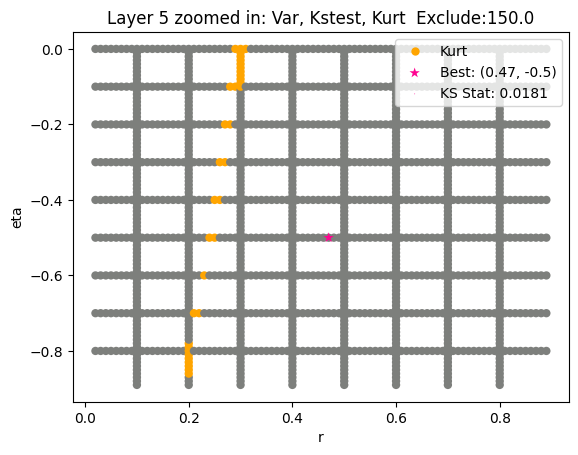

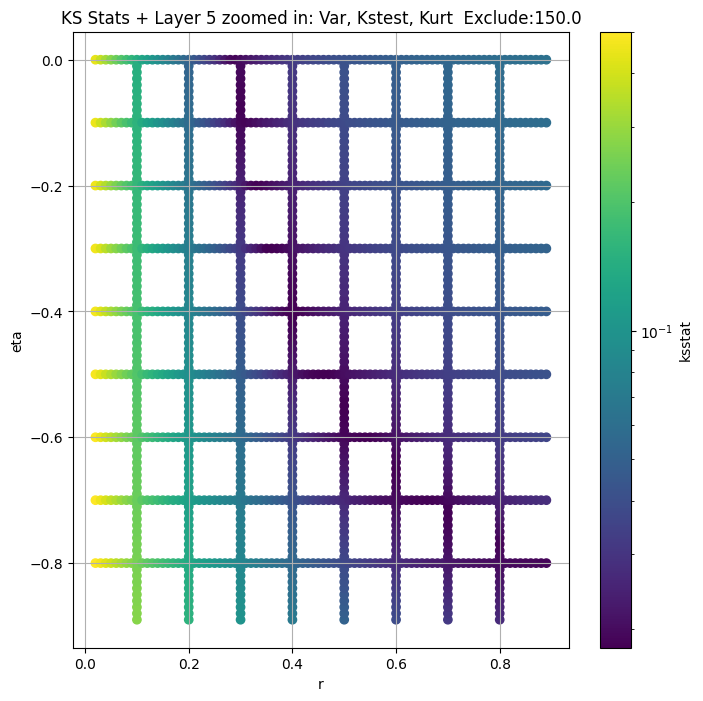

Layer 6


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + 100 = 175, ksstat: 0.009370848905086326, var: 46.00159454345703


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + 75 = 150, ksstat: 0.009344724796084003, var: 46.50727081298828


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + 50 = 125, ksstat: 0.00950093596024204, var: 47.04305648803711


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + 25 = 100, ksstat: 0.009386042977076958, var: 47.61656188964844


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + 0 = 75, ksstat: 0.00909010908031882, var: 48.238441467285156


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + -25 = 50, ksstat: 0.00917646873749256, var: 48.92889404296875


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + -50 = 25, ksstat: 0.009096669770558563, var: 49.730533599853516


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 6, 75.0 + -75 = 0, ksstat: 0.009139242025446692, var: 50.96315383911133
Number of samples: 100000, Without approximation : 1810432


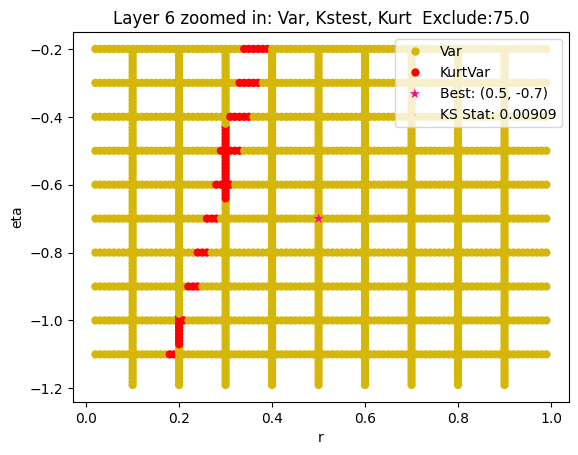

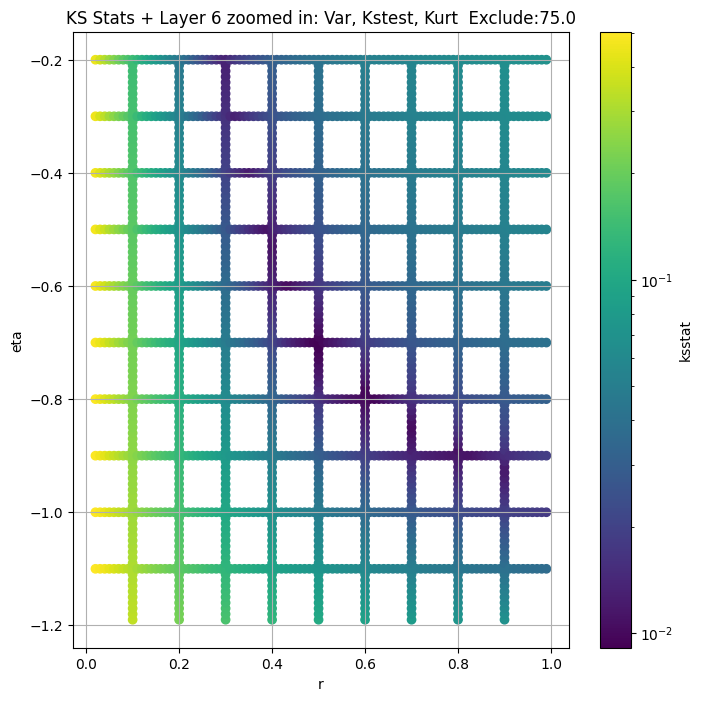

Layer 7


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.006357641621804855, var: 10.358567237854004


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.005998509713510902, var: 10.498008728027344


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.005812562630809648, var: 10.649341583251953


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.006077383594483066, var: 10.818001747131348


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.005898570134885817, var: 11.015016555786133


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.0051047063704852125, var: 11.33162784576416
Number of samples: 100000, Without approximation : 7241728


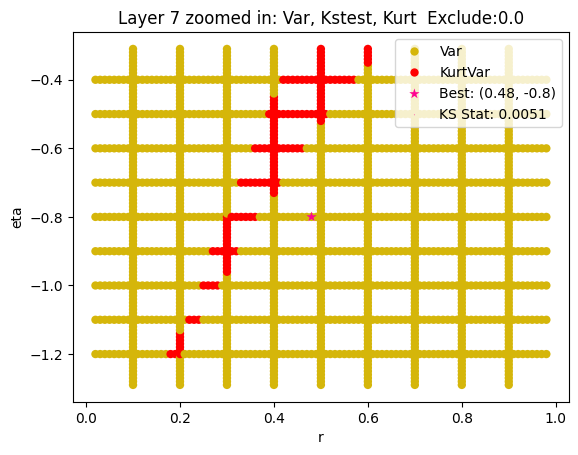

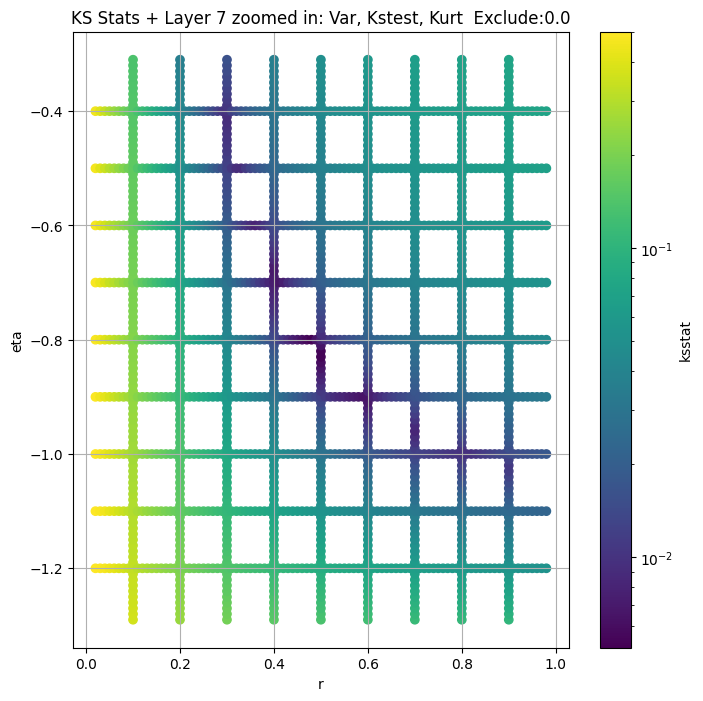

Layer 8


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.005478852421297198, var: 2.328131675720215


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.004942003265688721, var: 2.3644139766693115


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.004946444235666481, var: 2.4049644470214844


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.004346765221467042, var: 2.4525766372680664


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.0038911008385307255, var: 2.5346262454986572
Number of samples: 100000, Without approximation : 28966912


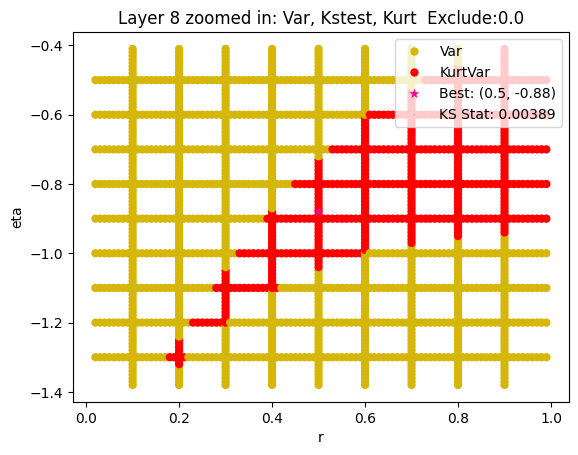

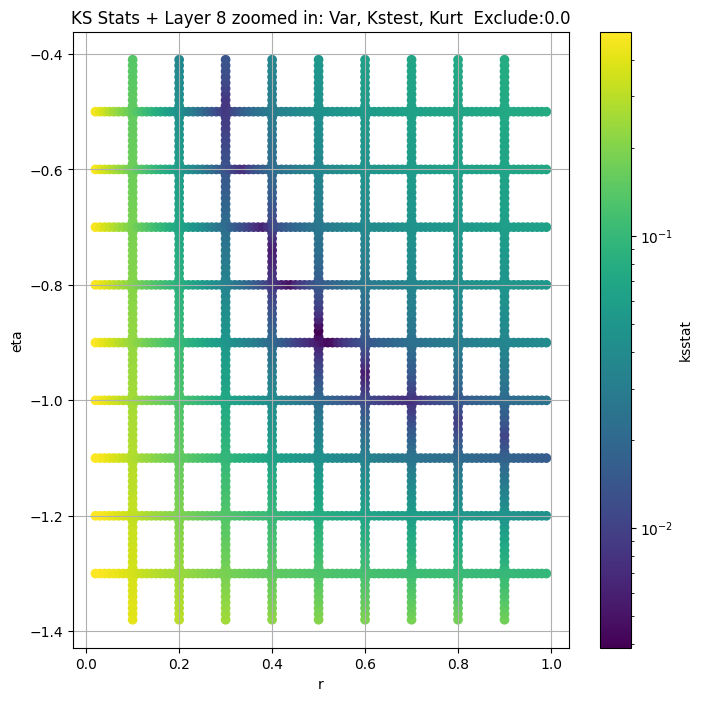

Layer 9


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.006296021737106083, var: 0.5460131764411926


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.00588039537459184, var: 0.5552640557289124


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.005520170664141677, var: 0.5656430721282959


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.0052996548868187165, var: 0.5778948068618774


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.005294320368271155, var: 0.6009948253631592
Number of samples: 100000, Without approximation : 115867648


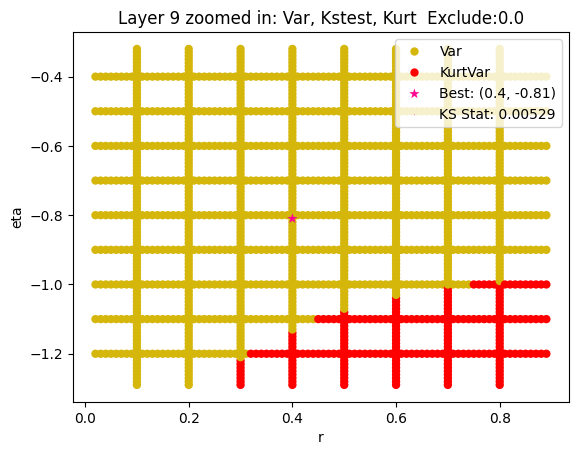

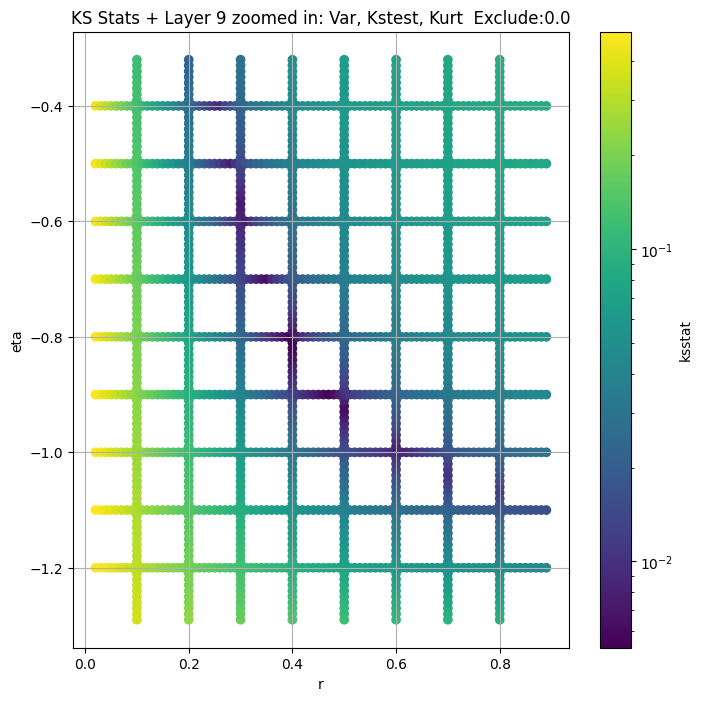

Layer 10


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + 100 = 200, ksstat: 0.006146678777615412, var: 0.12189298868179321


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + 75 = 175, ksstat: 0.005792292102941146, var: 0.12379226088523865


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + 50 = 150, ksstat: 0.005806990149153368, var: 0.12581636011600494


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + 25 = 125, ksstat: 0.005529566514831941, var: 0.12799030542373657


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + 0 = 100, ksstat: 0.0052279483005672756, var: 0.13035044074058533


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + -25 = 75, ksstat: 0.004746941321670639, var: 0.13295409083366394


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + -50 = 50, ksstat: 0.004434933475394032, var: 0.1359015703201294


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + -75 = 25, ksstat: 0.004419980564175585, var: 0.13942380249500275


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 10, 100.0 + -100 = 0, ksstat: 0.0035734238469729007, var: 0.1466083526611328
Number of samples: 100000, Without approximation : 463470592


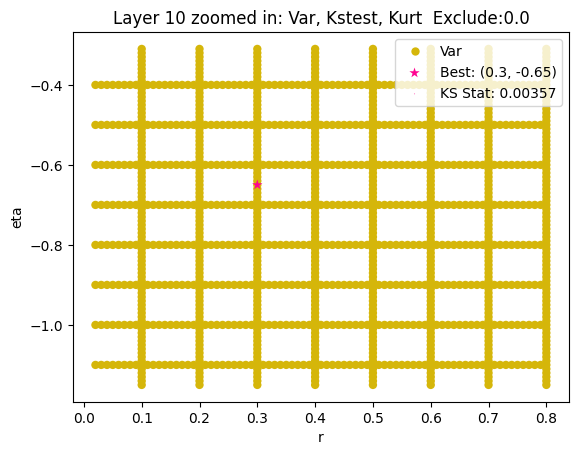

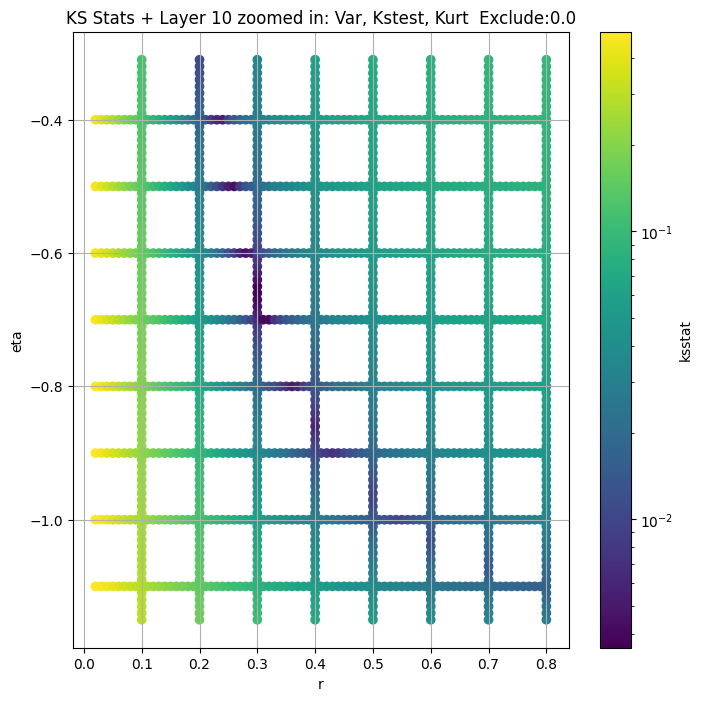

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      18950.691000  18034.914000  19884.934000   0.555051    0.361059   
3       4388.561500   4176.722000   4603.724600   1.555216    1.292626   
4       1007.044070    950.235700   1065.644300   2.910003    2.394928   
5        229.104720    214.613650    244.353060   4.434873    3.485563   
6         50.963154     47.393555     54.791560   5.817626    4.435262   
7         11.331628     10.483869     12.258407   7.224944    5.307698   
8          2.534626      2.331055      2.771307   9.098009    5.957001   
9          0.600995      0.548408      0.671857  12.860447    6.738958   
10         0.146608      0.131844      0.169582  20.812674    8.569079   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.770263           7072             0.049307        4.5         -0.3   
3        1.843574          28288             0.038770        0.2          2.9   
4        3.597748         113152             0.030812        0.9         -0.6   
5        6.828188         452608             0.018110        0.4         -0.4   
6       10.859207        1810432             0.009090        0.5         -0.7   
7       14.322908        7241728             0.006393        0.5         -0.8   
8       24.061966       28966912             0.005678        0.5         -0.9   
9       48.073174      115867648             0.005399        0.4         -0.8   
10      91.798670      463470592             0.005228        0.4         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       35417.588933                     0.0        18950.691000   
3           0.000527                    50.0         4081.398438   
4         897.767659                   150.0          952.673950   
5           9.980145                    75.0          211.666473   
6          11.595779                    75.0           48.238440   
7           3.278279                    25.0           11.331628   
8           0.960086                     0.0            2.534626   
9           0.066668                     0.0            0.600995   
10          0.014460                   100.0            0.146608   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.016126          0.049307    4.50     -0.30   
3                     0.008069          0.038769    0.22      2.60   
4                     0.004036          0.030788    1.00     -0.64   
5                     0.002018          0.018095    0.47     -0.50   
6                     0.001009          0.009090    0.50     -0.70   
7                     0.000505          0.005105    0.48     -0.80   
8                     0.000252          0.003891    0.50     -0.88   
9                     0.000126          0.005294    0.40     -0.81   
10                    0.000063          0.003573    0.30     -0.65   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      35417.588933                  0.0          745  
3          0.004581                 75.0         1255  
4       1107.760407                125.0         1989  
5         26.912685                150.0         5661  
6         11.595779                 75.0        21216  
7          2.883177                  0.0        71604  
8          0.912524                  0.0       127296  
9          0.068499                  0.0        63648  
10         0.001582                  0.0       143208

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

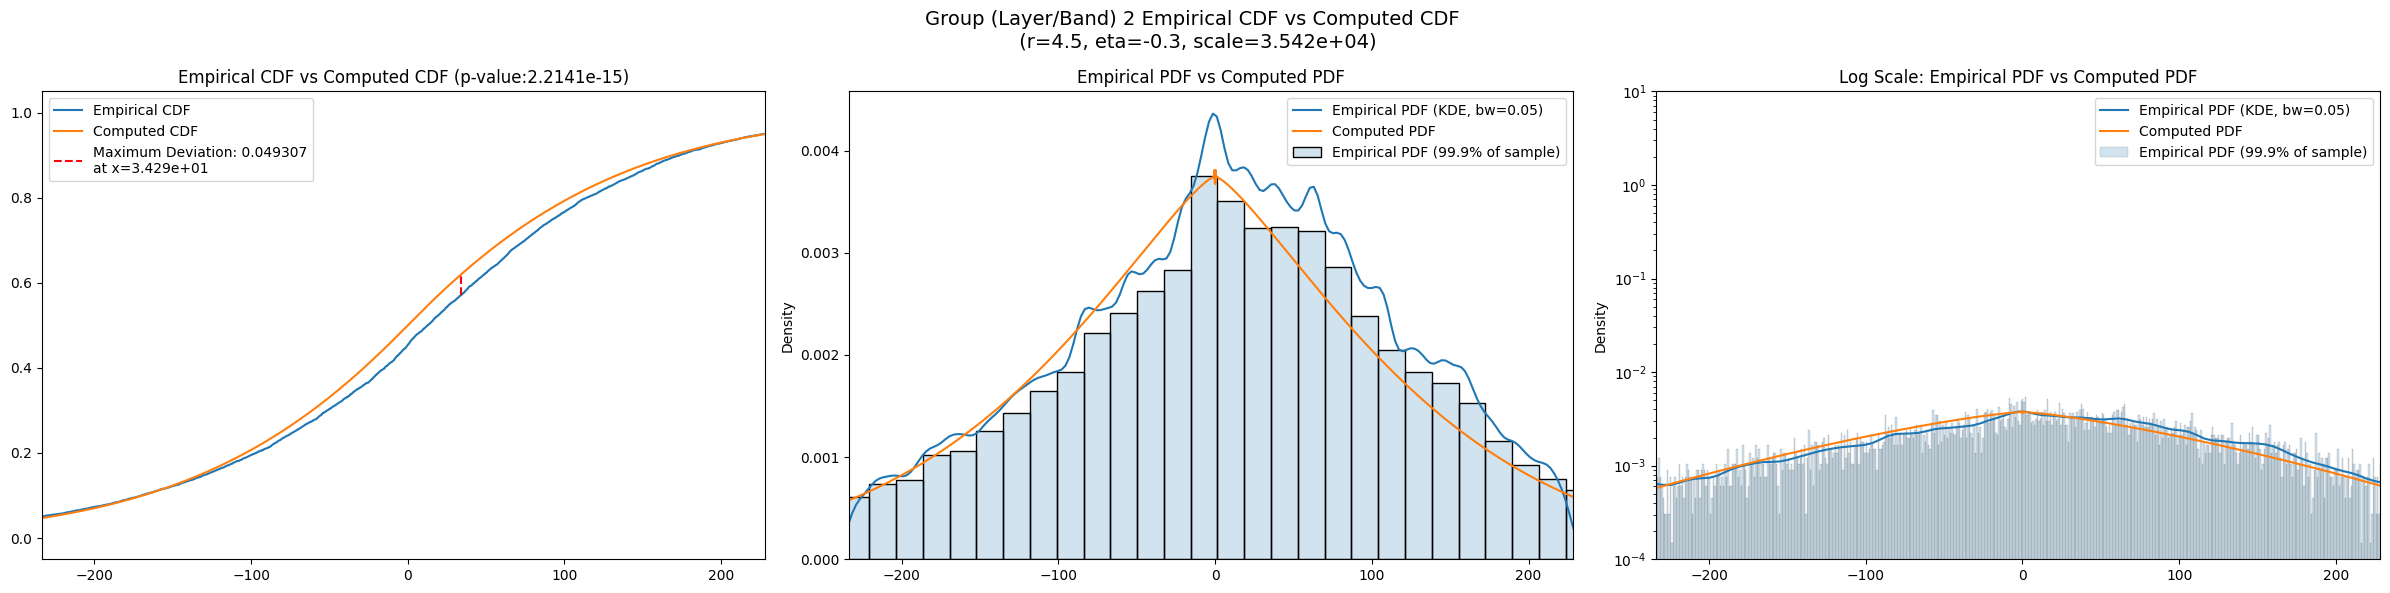

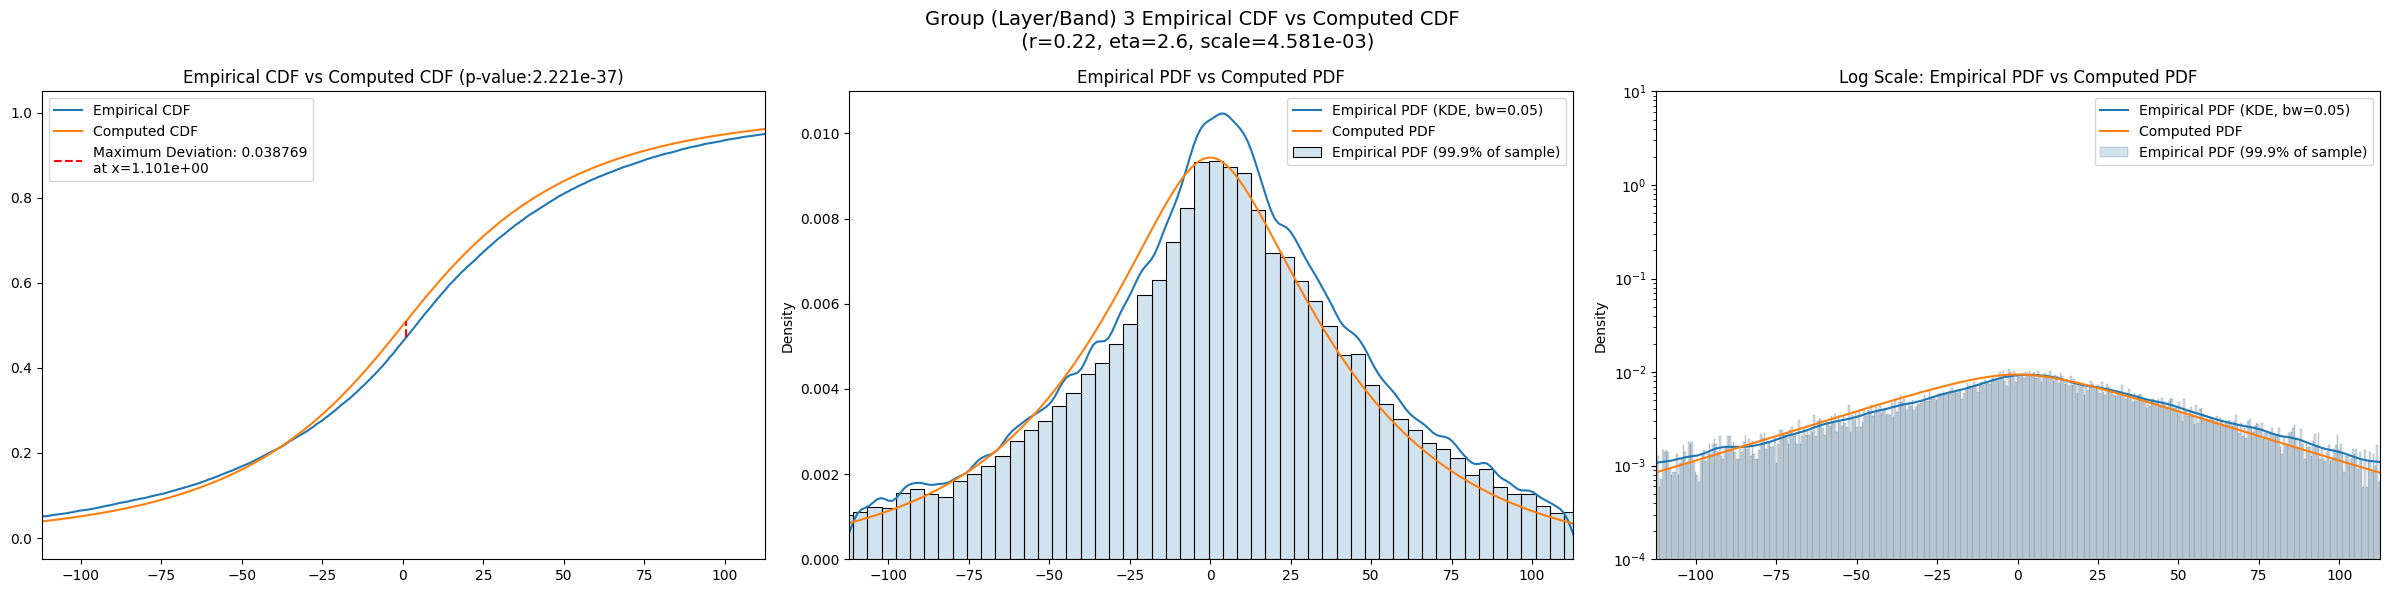

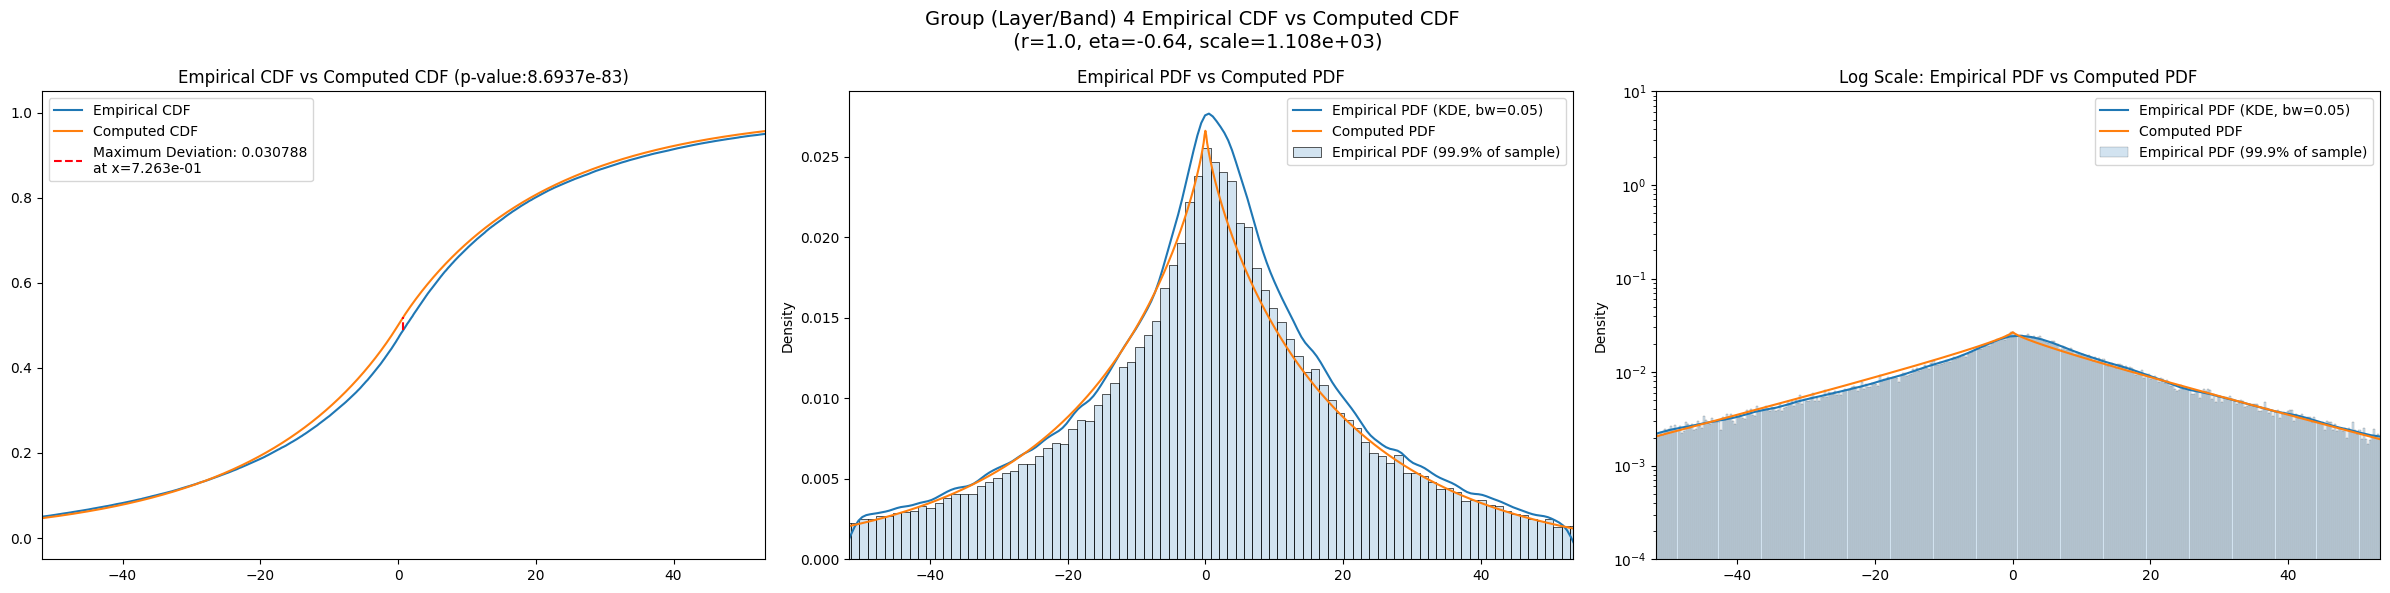

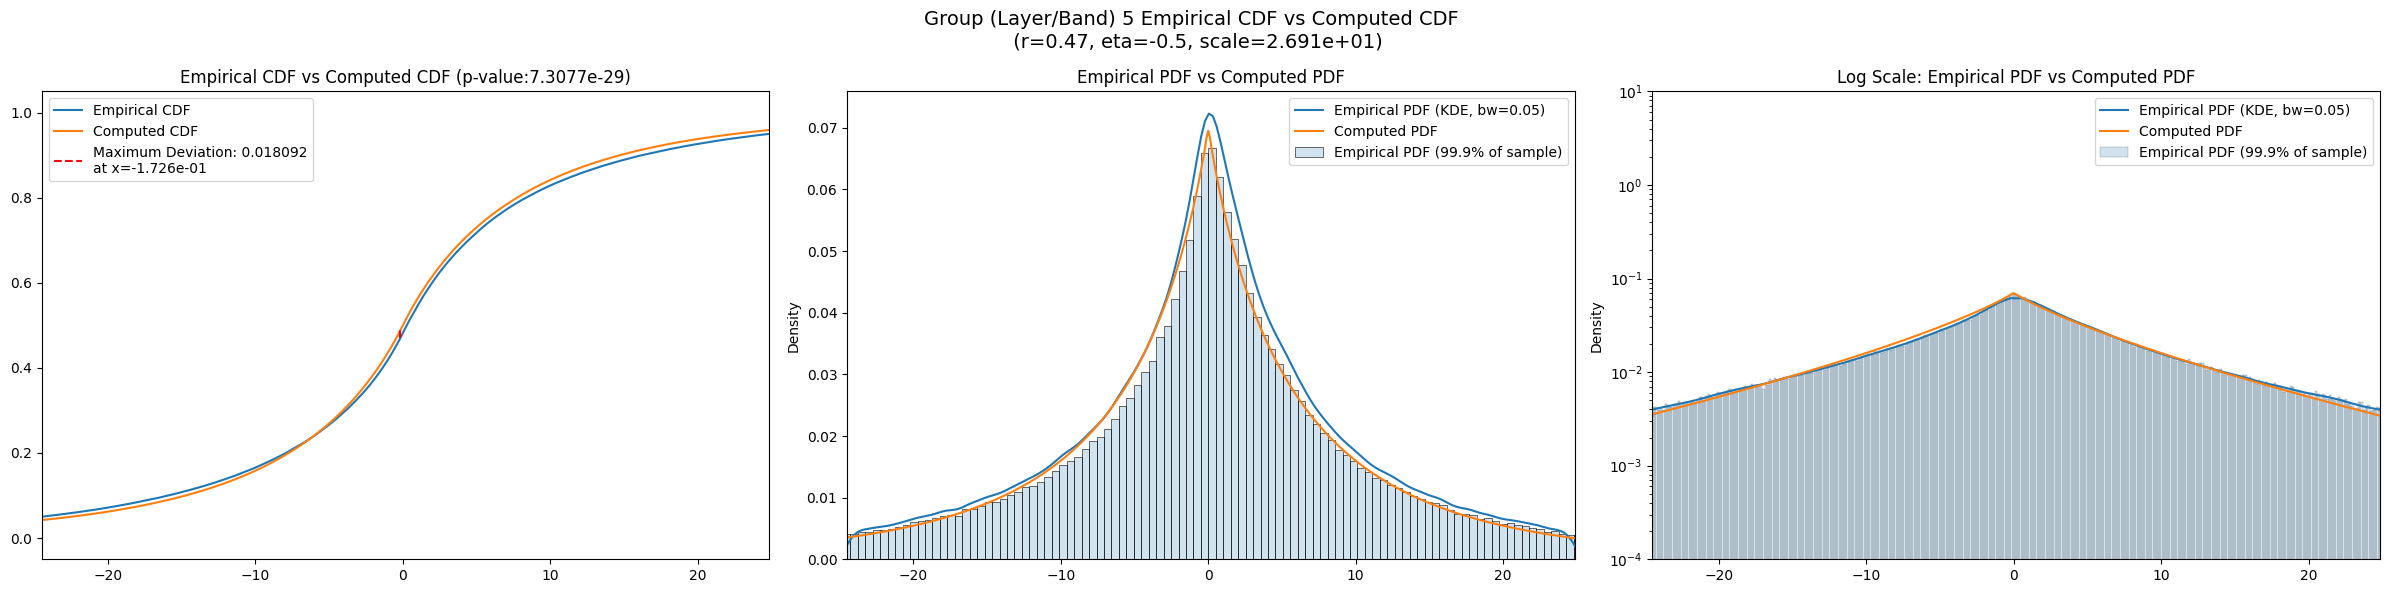

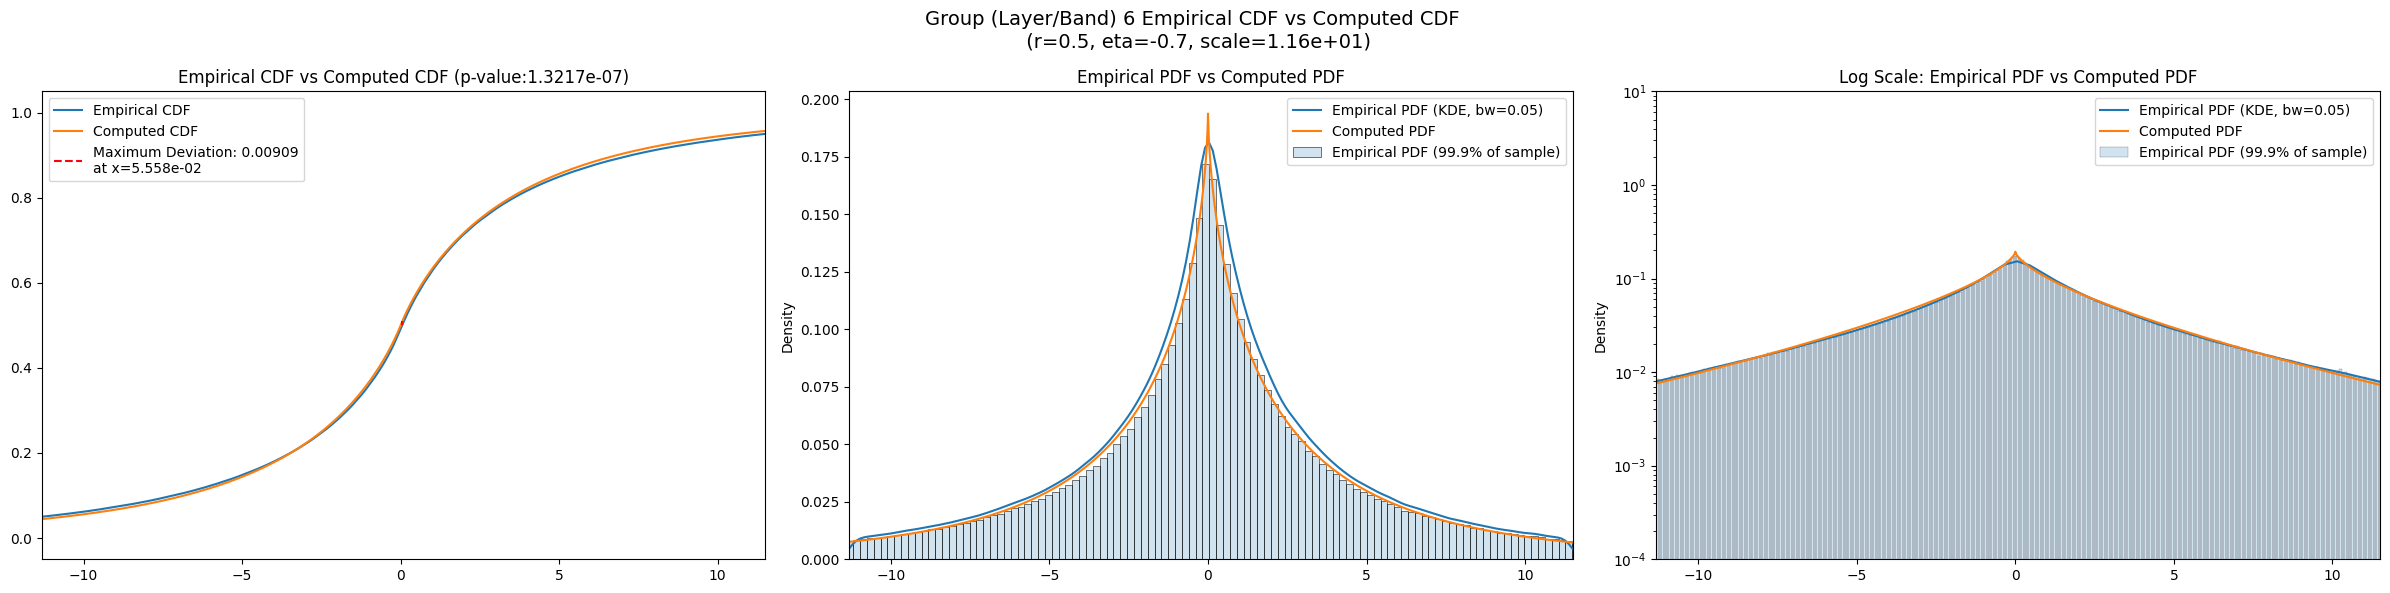

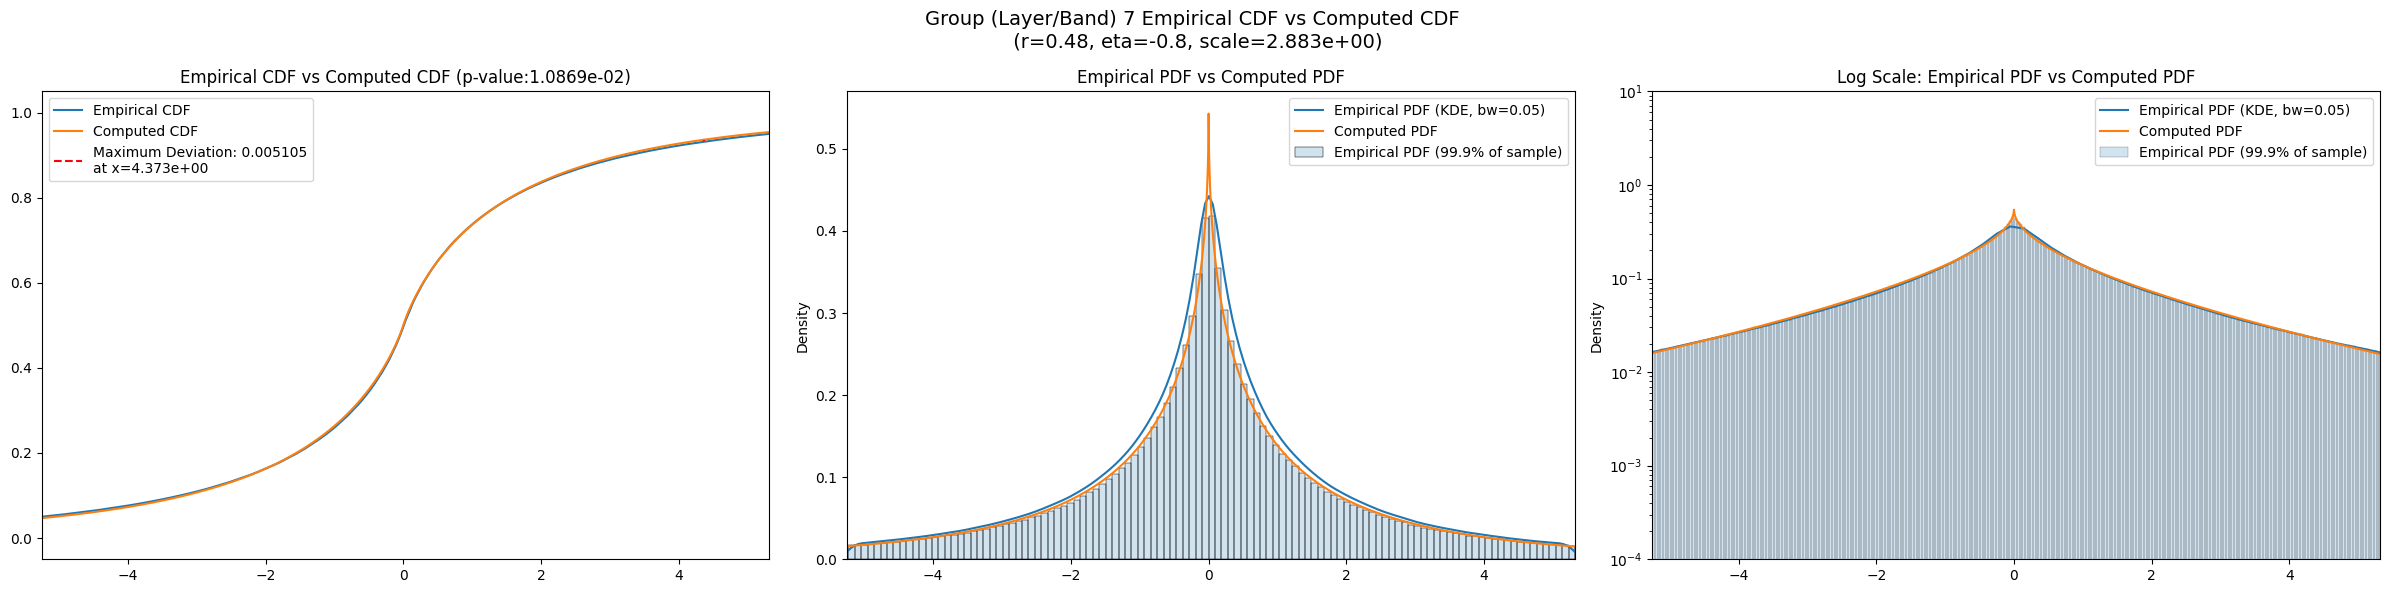

C:\Users\yashd\AppData\Local\Temp\ipykernel_18668\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


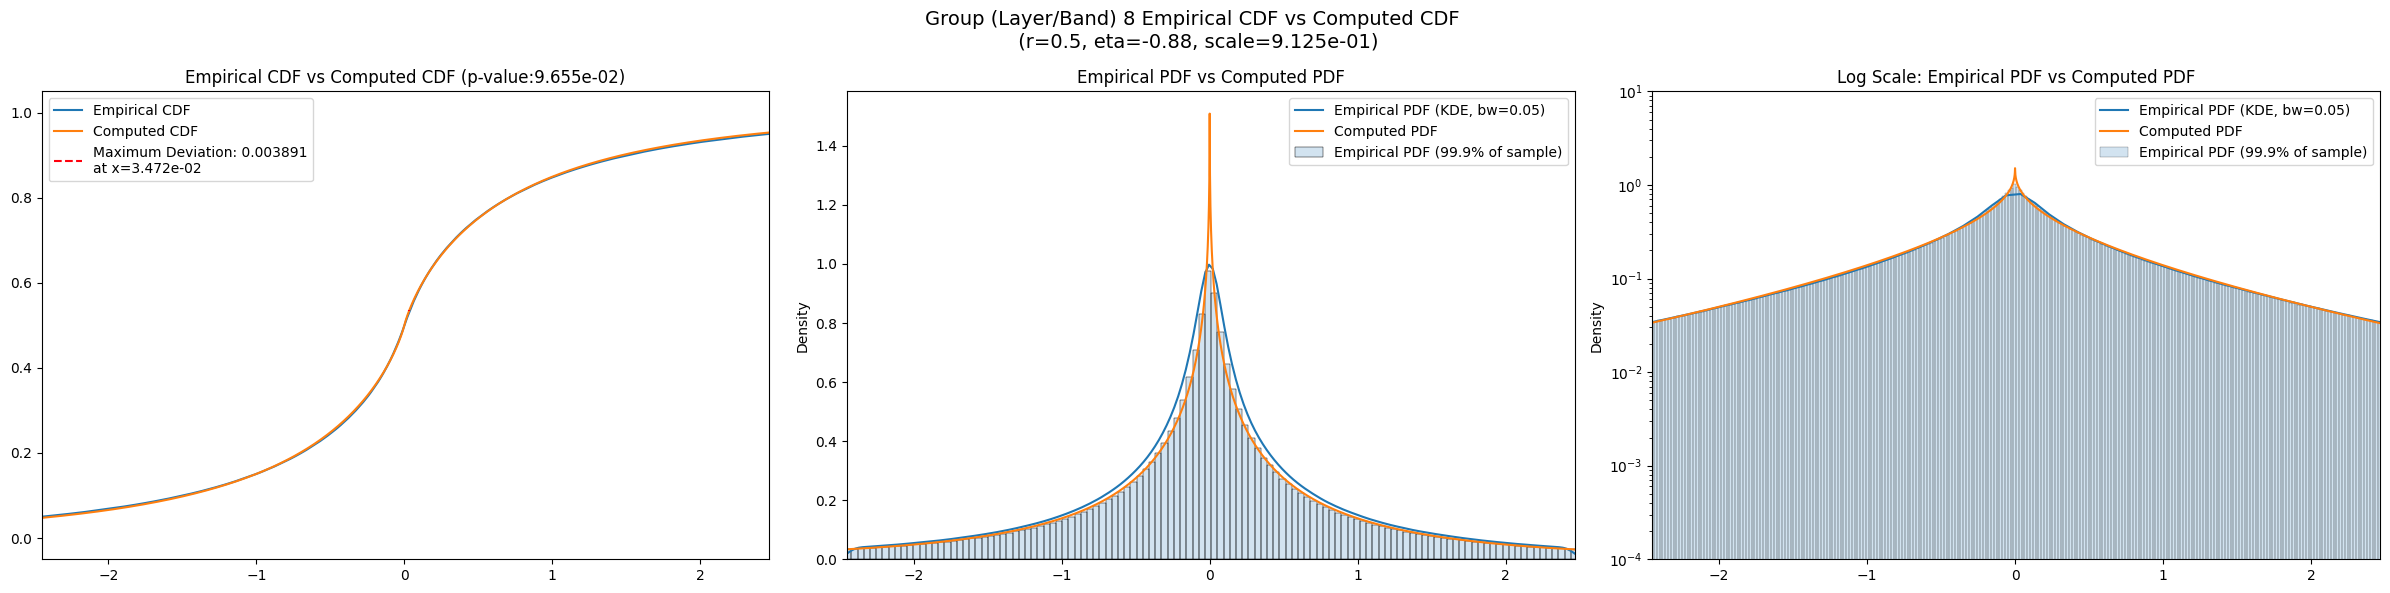

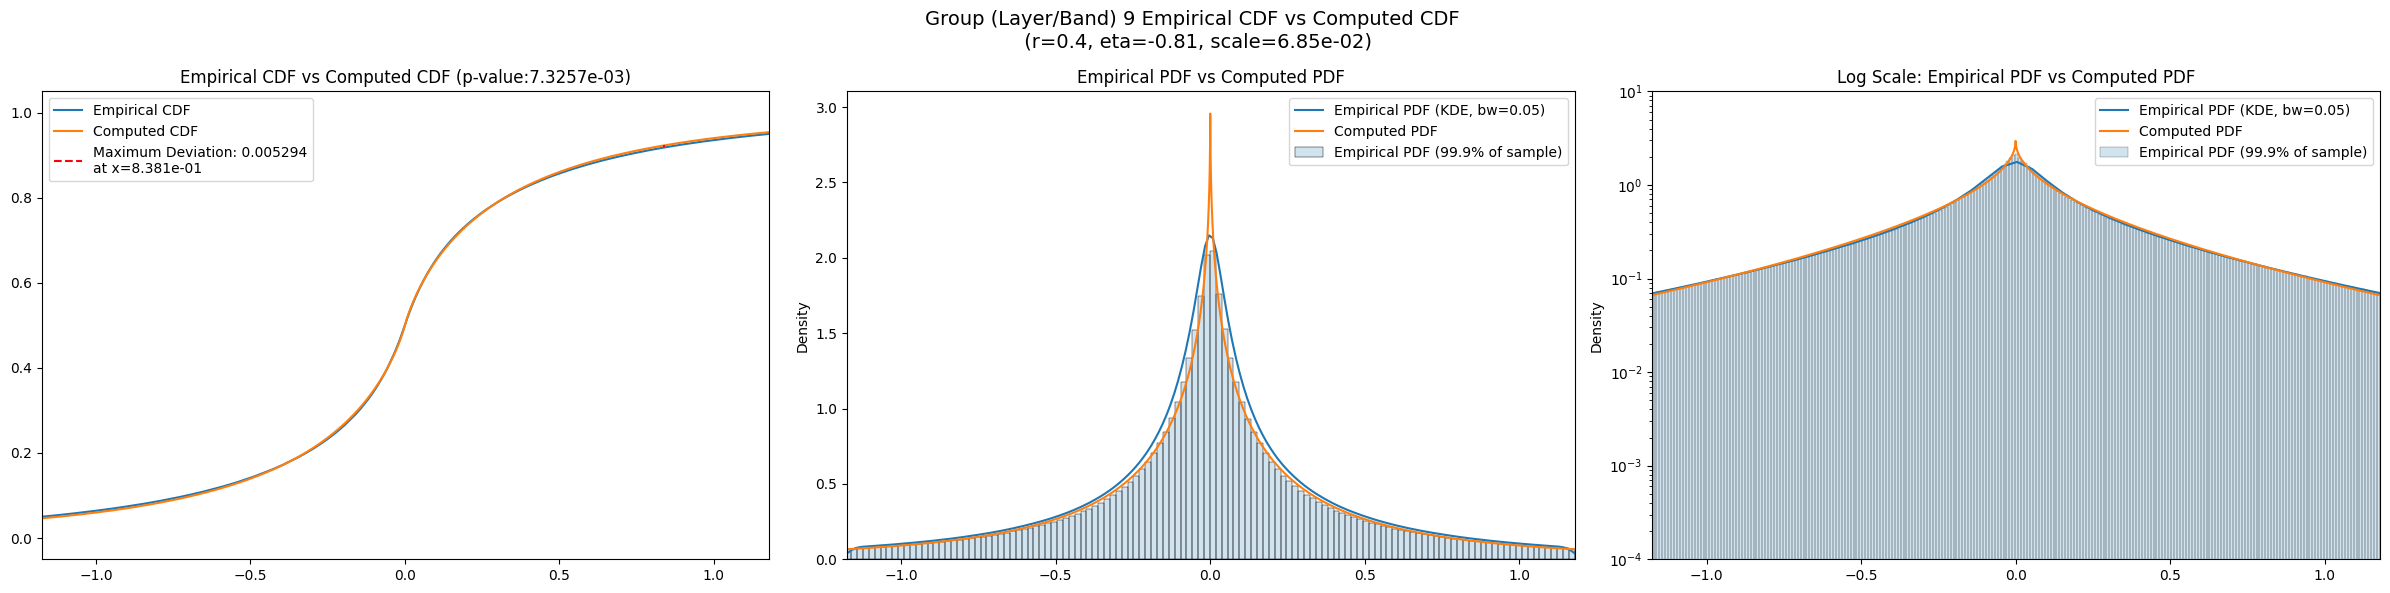

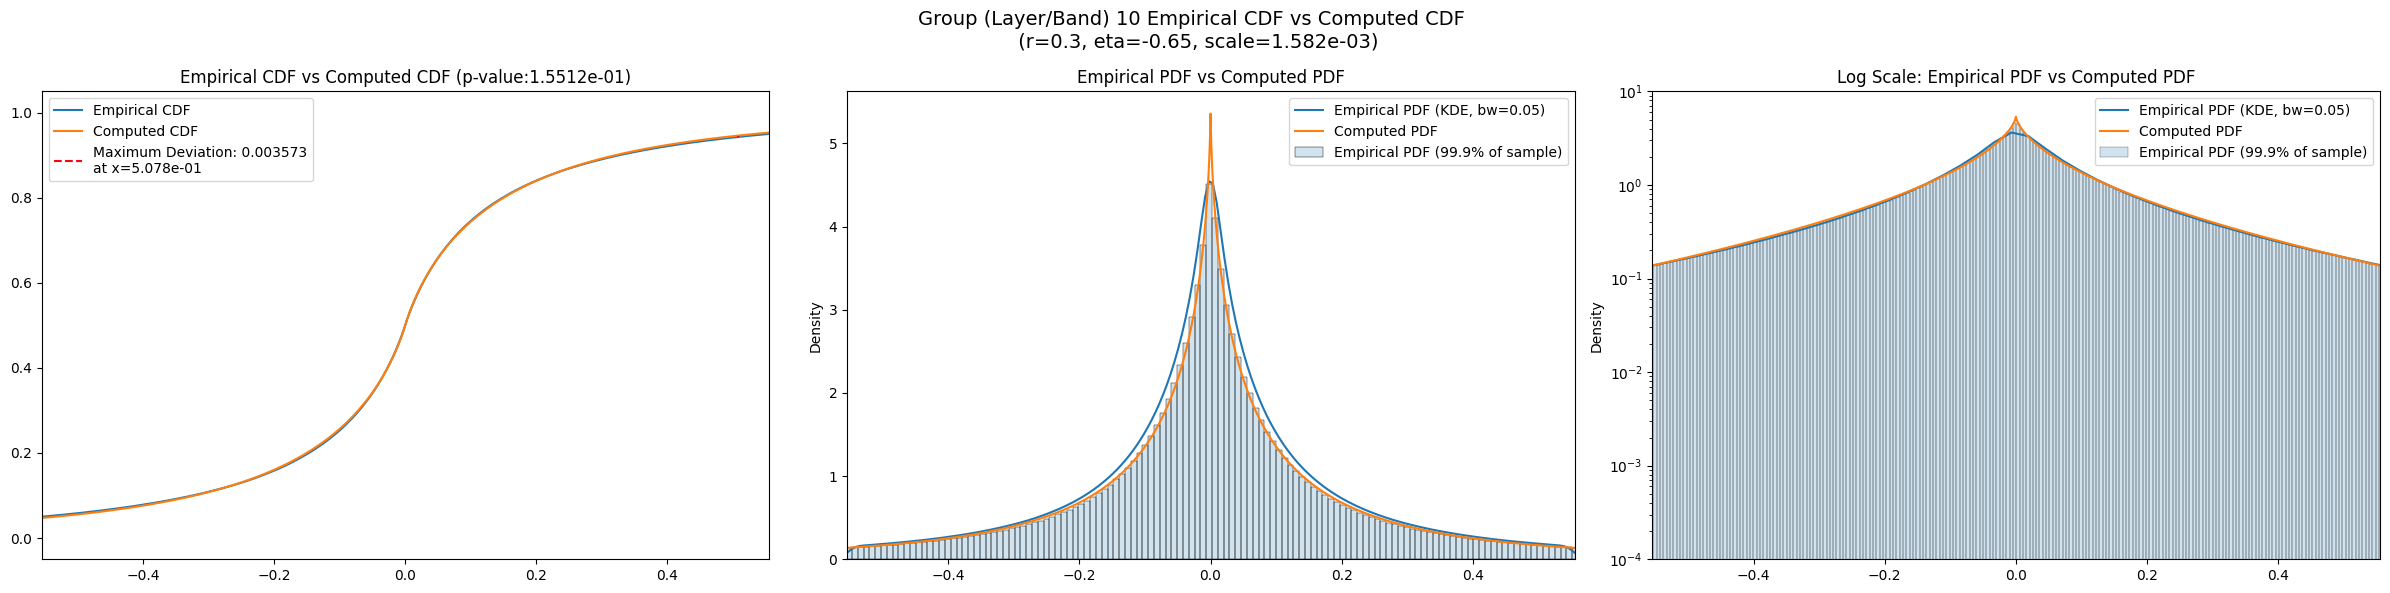

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      18950.691000  18034.914000  19884.934000   0.555051    0.361059   
3       4388.561500   4176.722000   4603.724600   1.555216    1.292626   
4       1007.044070    950.235700   1065.644300   2.910003    2.394928   
5        229.104720    214.613650    244.353060   4.434873    3.485563   
6         50.963154     47.393555     54.791560   5.817626    4.435262   
7         11.331628     10.483869     12.258407   7.224944    5.307698   
8          2.534626      2.331055      2.771307   9.098009    5.957001   
9          0.600995      0.548408      0.671857  12.860447    6.738958   
10         0.146608      0.131844      0.169582  20.812674    8.569079   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.770263           7072             0.049307        4.5         -0.3   
3        1.843574          28288             0.038770        0.2          2.9   
4        3.597748         113152             0.030812        0.9         -0.6   
5        6.828188         452608             0.018110        0.4         -0.4   
6       10.859207        1810432             0.009090        0.5         -0.7   
7       14.322908        7241728             0.006393        0.5         -0.8   
8       24.061966       28966912             0.005678        0.5         -0.9   
9       48.073174      115867648             0.005399        0.4         -0.8   
10      91.798670      463470592             0.005228        0.4         -0.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      112.753000              0.050851          2.477070e-16   
3      ...       50.082100              0.046461          1.674740e-53   
4      ...       22.303800              0.050299         3.119360e-249   
5      ...        9.971210              0.051979          0.000000e+00   
6      ...        4.445820              0.053950          0.000000e+00   
7      ...        1.972320              0.056636          0.000000e+00   
8      ...        0.894950              0.058433          0.000000e+00   
9      ...        0.414524              0.060958          0.000000e+00   
10     ...        0.194434              0.059451          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         127.259000             0.048531         6.491570e-15  97.032700   
3          51.890000             0.038887         1.326260e-37  38.099200   
4          19.116500             0.030847         5.653770e-94  15.750000   
5           8.568920             0.025945        4.159850e-265   6.946210   
6           3.857800             0.026939         0.000000e+00   3.087200   
7           1.715100             0.029623         0.000000e+00   1.361820   
8           0.778798             0.031371         0.000000e+00   0.618868   
9           0.361696             0.033744         0.000000e+00   0.287143   
10          0.170582             0.032453         0.000000e+00   0.134314   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.049940   9.090710e-16          2.214132e-15  
3           0.039181   3.604760e-38          2.220998e-37  
4           0.034375  1.345250e-116          1.282733e-93  
5           0.030770   0.000000e+00         3.657991e-129  
6           0.030172   0.000000e+00         2.295283e-130  
7           0.031873   0.000000e+00         2.468004e-164  
8           0.033391   0.000000e+00          0.000000e+00  
9           0.035055   0.000000e+00          0.000000e+00  
10          0.032671   0.000000e+00       

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.049307                 0.016126          0.049307   
3                 0.038770                 0.008069          0.038769   
4                 0.030812                 0.004036          0.030788   
5                 0.018110                 0.002018          0.018095   
6                 0.009090                 0.001009          0.009090   
7                 0.006393                 0.000505          0.005105   
8                 0.005678                 0.000252          0.003891   
9                 0.005399                 0.000126          0.005294   
10                0.005228                 0.000063          0.003573   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.050851             0.048531       0.049940  
3                  0.046461             0.038887       0.039181  
4                  0.050299             0.030847       0.034375  
5                  0.051979             0.025945       0.030770  
6                  0.053950             0.026939       0.030172  
7                  0.056636             0.029623       0.031873  
8                  0.058433             0.031371       0.033391  
9                  0.060958             0.033744       0.035055  
10                 0.059451             0.032453       0.032671

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            18950.691000          0.049307    4.50     -0.30  35417.588933   
3             4081.398438          0.038769    0.22      2.60      0.004581   
4              952.673950          0.030788    1.00     -0.64   1107.760407   
5              211.666473          0.018095    0.47     -0.50     26.912685   
6               48.238440          0.009090    0.50     -0.70     11.595779   
7               11.331628          0.005105    0.48     -0.80      2.883177   
8                2.534626          0.003891    0.50     -0.88      0.912524   
9                0.600995          0.005294    0.40     -0.81      0.068499   
10               0.146608          0.003573    0.30     -0.65      0.001582   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                     75.0  
4                    125.0  
5                    150.0  
6                     75.0  
7                      0.0  
8                      0.0  
9                      0.0  
10                     0.0